In [82]:
import pandas as pd
import time
import datetime
import collections
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder

In [83]:
df = pd.read_csv("training_set_VU_DM.csv")
df_test = pd.read_csv("test_set_VU_DM.csv")
#df = pd.read_csv("sample_training_set.csv")

# Get a sample from the training dataset
#df = df.sample(n=500000)
#df.to_csv('sample_training_set.csv')

In [84]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
visitor_hist_starrating,312,4706481,251866,float64,5.0,1.41
visitor_hist_adr_usd,7799,4705359,252988,float64,1958.7,0.0
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,7364,4950983,float64,5.0,0.0


In [85]:
df['srch_query_affinity_score'] = np.exp(df['srch_query_affinity_score'])
df_test['srch_query_affinity_score'] = np.exp(df_test['srch_query_affinity_score'])



In [86]:
df['prop_log_historical_price'] = np.exp(df['prop_log_historical_price'])
df_test['prop_log_historical_price'] = np.exp(df_test['prop_log_historical_price'])

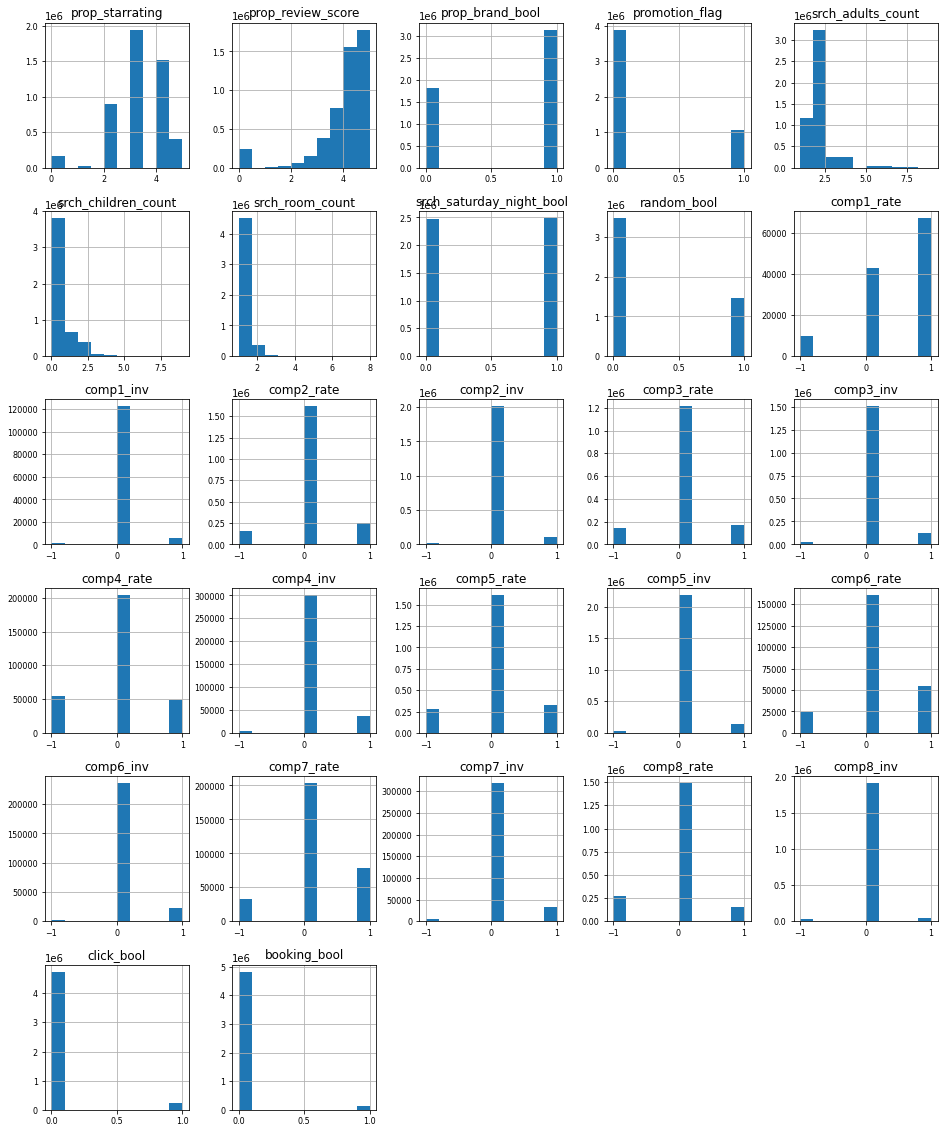

In [87]:
descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
descr3.remove('date_time')
descr3.remove('srch_id')
#df.boxplot(column=descr3, figsize=(16, 20))

In [88]:
#df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

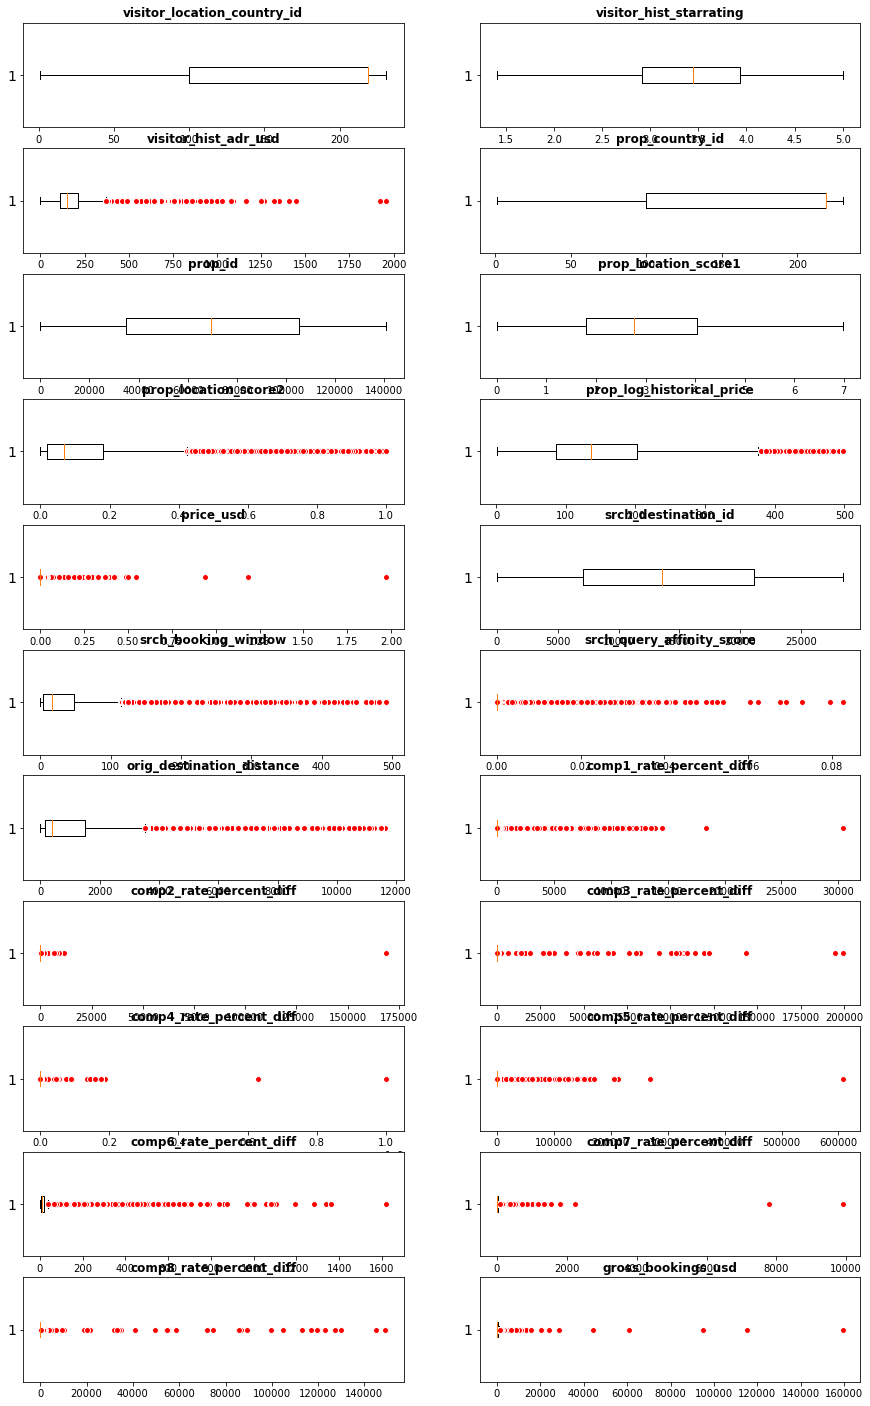

In [89]:
df_numerical = df[descr3]

red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

fig, axs = plt.subplots(11, 2, figsize=(15,25))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_numerical.iloc[:,i].dropna(), flierprops = red_circle, vert=False)
    ax.set_title(df_numerical.columns[i], fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)

plt.show()

<AxesSubplot:>

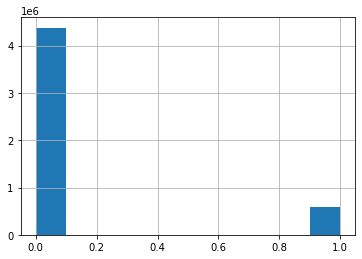

In [90]:
conditions = [(df['comp1_rate'].eq(-1) & df['comp1_inv'].ne(1)), 
              (df['comp2_rate'].eq(-1) & df['comp2_inv'].ne(1)), 
              (df['comp3_rate'].eq(-1) & df['comp3_inv'].ne(1)),  
              (df['comp4_rate'].eq(-1) & df['comp4_inv'].ne(1)), 
              (df['comp5_rate'].eq(-1) & df['comp5_inv'].ne(1)), 
              (df['comp6_rate'].eq(-1) & df['comp6_inv'].ne(1)), 
              (df['comp7_rate'].eq(-1) & df['comp7_inv'].ne(1)),  
              (df['comp8_rate'].eq(-1) & df['comp8_inv'].ne(1))]

choices = [1,1,1,1,1,1,1,1]

df['comp_cheaper'] = np.select(conditions, choices, default=0)

# and for test set
conditions2 = [(df_test['comp1_rate'].eq(-1) & df_test['comp1_inv'].ne(1)), 
              (df_test['comp2_rate'].eq(-1) & df_test['comp2_inv'].ne(1)), 
              (df_test['comp3_rate'].eq(-1) & df_test['comp3_inv'].ne(1)),  
              (df_test['comp4_rate'].eq(-1) & df_test['comp4_inv'].ne(1)), 
              (df_test['comp5_rate'].eq(-1) & df_test['comp5_inv'].ne(1)), 
              (df_test['comp6_rate'].eq(-1) & df_test['comp6_inv'].ne(1)), 
              (df_test['comp7_rate'].eq(-1) & df_test['comp7_inv'].ne(1)),  
              (df_test['comp8_rate'].eq(-1) & df_test['comp8_inv'].ne(1))]

choices2 = [1,1,1,1,1,1,1,1]

df_test['comp_cheaper'] = np.select(conditions2, choices2, default=0)
df_test['comp_cheaper'].hist()

In [91]:
# # combine comp 1-8 in variable bool whether booking is cheapest on booking.com or not
# # if cheaper and availible than yes/1
# df['comp_cheaper'] = np.nan
# for i in range(0,len(df),1):
#     if (df.at[i,'comp1_rate'] == -1 and df.at[i,'comp1_inv'] != 1) or (df.at[i,'comp2_rate'] == -1 and df.at[i,'comp2_inv'] != 1) or (df.at[i,'comp3_rate'] == -1 and df.at[i,'comp3_inv'] != 1) or (df.at[i,'comp4_rate'] == -1 and df.at[i,'comp4_inv'] != 1) or (df.at[i,'comp5_rate'] == -1 and df.at[i,'comp5_inv'] != 1) or (df.at[i,'comp6_rate'] == -1 and df.at[i,'comp6_inv'] != 1) or (df.at[i,'comp7_rate'] == -1 and df.at[i,'comp7_inv'] != 1) or (df.at[i,'comp8_rate'] == -1 and df.at[i,'comp8_inv'] != 1):
#         df.at[i,'comp_cheaper'] = 1
#     else:
#         df.at[i,'comp_cheaper'] = 0
# df['comp_cheaper'].hist() # 582754 1 en 4375593 0

# # comp cheaper for test df
# df_test['comp_cheaper'] = np.nan
# for i in range(0,len(df_test),1):
#     if (df_test.at[i,'comp1_rate'] == -1 and df_test.at[i,'comp1_inv'] != 1) or (df_test.at[i,'comp2_rate'] == -1 and df_test.at[i,'comp2_inv'] != 1) or (df_test.at[i,'comp3_rate'] == -1 and df_test.at[i,'comp3_inv'] != 1) or (df_test.at[i,'comp4_rate'] == -1 and df_test.at[i,'comp4_inv'] != 1) or (df_test.at[i,'comp5_rate'] == -1 and df_test.at[i,'comp5_inv'] != 1) or (df_test.at[i,'comp6_rate'] == -1 and df_test.at[i,'comp6_inv'] != 1) or (df_test.at[i,'comp7_rate'] == -1 and df_test.at[i,'comp7_inv'] != 1) or (df_test.at[i,'comp8_rate'] == -1 and df_test.at[i,'comp8_inv'] != 1):
#         df_test.at[i,'comp_cheaper'] = 1
#     else:
#         df_test.at[i,'comp_cheaper'] = 0
# df_test['comp_cheaper'].hist() # 580166 1 and 4378181 0

In [92]:
#df['srch_query_affinity_score'] = np.exp(df['srch_query_affinity_score'])
#df_test['srch_query_affinity_score'] = np.exp(df_test['srch_query_affinity_score'])

In [93]:
for c in df.columns:
    if c == 'prop_review_score':
        df[c] = df[c].fillna(df[c].mode()[0])
    elif c == 'prop_location_score2':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].mean()
    elif c == 'orig_destination_distance':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].mean()
    elif c == 'gross_bookings_usd':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].median()
    elif c == 'srch_query_affinity_score':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].median()

for c in df_test.columns:
    if c == 'prop_review_score':
        df_test[c] = df_test[c].fillna(df_test[c].mode()[0])
    elif c == 'prop_location_score2':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].mean()
    elif c == 'orig_destination_distance':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].mean()
    elif c == 'gross_bookings_usd':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].median()
    elif c == 'srch_query_affinity_score':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].median()
        
        

print("count of NULL values after imputation\n")
print(df['prop_review_score'].isnull().sum())
print(df['prop_location_score2'].isnull().sum())   
print(df['gross_bookings_usd'].isnull().sum())

count of NULL values after imputation

0
0
0


In [94]:
previously_purchased_hotels_train = []
columns = ['visitor_hist_starrating', 'visitor_hist_adr_usd']
for i in df['visitor_hist_starrating'].values:
    if i >= 0:
        previously_purchased_hotels_train.append(1)
    else:
        previously_purchased_hotels_train.append(0)
        
previously_purchased_hotels_test = []

for i in df_test['visitor_hist_starrating'].values:
    if i >= 0:
        previously_purchased_hotels_test.append(1)
    else:
        previously_purchased_hotels_test.append(0)


In [95]:
df.drop('visitor_hist_starrating', inplace = True, axis =1)
df.drop('visitor_hist_adr_usd', inplace = True, axis = 1)
df_test.drop('visitor_hist_starrating', inplace = True, axis =1)
df_test.drop('visitor_hist_adr_usd', inplace = True, axis = 1)
df.insert(6, 'visitor_hist_bool', previously_purchased_hotels_train)
df_test.insert(6, 'visitor_hist_bool', previously_purchased_hotels_test)
df.columns

MemoryError: Unable to allocate 1.18 GiB for an array with shape (32, 4958347) and data type float64

In [ ]:
# For train set
adults = df['srch_adults_count'].values
children = df['srch_children_count'].values

adults = list(adults)
children = list(children)

ratio_adults = [i/ (i+j) for i, j in zip(adults, children)]

df.drop('srch_adults_count', inplace=True, axis=1)
df.drop('srch_children_count', inplace=True, axis=1)
df.insert(22, 'adult_ratio', ratio_adults)

# For test set

adults = df_test['srch_adults_count'].values
children = df_test['srch_children_count'].values

adults = list(adults)
children = list(children)

ratio_adults = [i/ (i+j) for i, j in zip(adults, children)]

df_test.drop('srch_adults_count', inplace=True, axis=1)
df_test.drop('srch_children_count', inplace=True, axis=1)
df_test.insert(22, 'adult_ratio', ratio_adults)

In [ ]:
print(len(df.columns), len(df_test.columns))

In [ ]:
df.columns

In [ ]:
# Drop the comp rate columns to save storage, as we created new column for this and 
df = df.drop(['comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff'], axis=1)

df_test = df_test.drop(['comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff'], axis=1)


In [ ]:
one_user = df[df['srch_id']==23423]
one_user[['position', 'booking_bool']]

In [ ]:
print(df.columns)

df_descr_two = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr_two.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr_two

# transformation

prop_location_score2 = sqrt

srch_booking_window = log

orig_destination_distance = log


In [ ]:
df[['srch_booking_window', 'orig_destination_distance']] = np.log(df[['srch_booking_window', 'orig_destination_distance']].replace(0, np.nan))
df_test[['srch_booking_window', 'orig_destination_distance']] = np.log(df_test[['srch_booking_window', 'orig_destination_distance']].replace(0, np.nan))

In [ ]:
df['prop_location_score2'] = np.sqrt(df['prop_location_score2'])
df_test['prop_location_score2'] = np.sqrt(df_test['prop_location_score2'])

# Outlier removal of price_usd

In [ ]:
red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

plt.boxplot(df['price_usd'], flierprops = red_circle, vert=False)
plt.title("\"Price_usd\" before outlier removal", fontweight = 'bold')
#plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel("Price (USD)")
plt.yticks([])
plt.show()

In [ ]:
df.drop(df[df['price_usd'] > 7500000].index, inplace=True)
df_test.drop(df_test[df_test['price_usd'] > 7500000].index, inplace=True)

In [ ]:
plt.boxplot(df['price_usd'], flierprops = red_circle, vert=False)
plt.title("\"Price_usd\" after outlier removal", fontweight = 'bold')
plt.yticks([])
plt.xlabel("Price (USD)")
plt.show()

Text(0.5, 0, 'Price (USD)')

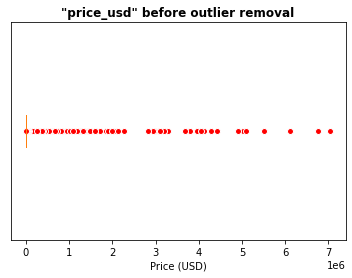

In [80]:
plt.boxplot(df_test['price_usd'], flierprops = red_circle, vert=False)
plt.title("\"price_usd\" before outlier removal", fontweight = 'bold')
plt.yticks([])
plt.xlabel("Price (USD)")

#  ----------------------------------XGBoost------------------------------------------------------------

In [69]:
# Make training and validation split - based on search id

# we exclude the columns that are not in the test set

df1 = df[df['srch_id']<= 200000]
df2 = df[df['srch_id']> 200000]

X_train = df1.loc[:, df1.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]
y_train = df1.loc[:, df1.columns.isin(['booking_bool'])]

X_val = df2.loc[:, df2.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]
y_val = df2.loc[:, df2.columns.isin(['booking_bool'])]

print(X_train.shape, X_val.shape)
# Set some features to type category to help xgboost
X_train[['site_id', 'prop_id','visitor_location_country_id','prop_review_score',
       'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 
        'srch_length_of_stay', 'srch_booking_window', 'srch_room_count', 
         'srch_saturday_night_bool', 'random_bool']].astype("category")
X_val[['site_id', 'prop_id','visitor_location_country_id','prop_review_score',
       'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 
        'srch_length_of_stay', 'srch_booking_window', 'srch_room_count', 
         'srch_saturday_night_bool', 'random_bool']].astype("category")
print('done')

(2978460, 23) (1979884, 23)
done


In [70]:
# Fit and train the model
clf2 = xgb.XGBClassifier(tree_method="approx", enable_categorical=True, use_label_encoder=False, max_depth=5)
clf2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [71]:
# Score the training data
print(clf2.feature_names_in_)
print(clf2.feature_importances_)
score = clf2.score(X_train, y_train, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_train)
print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_train_result = df1.loc[:, df1.columns.isin(['srch_id', 'prop_id', 'booking_bool', 'position'])]
df_train_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted_train = df_train_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted_train[['srch_id', 'prop_id', "booking_pred_prob", 'booking_bool', 'position']]
df_sorted_train['position_rank'] = df_sorted_train.groupby('srch_id')['booking_pred_prob'].rank(ascending=False)
df_sorted_train

['site_id' 'visitor_location_country_id' 'prop_country_id' 'prop_id'
 'visitor_hist_bool' 'prop_starrating' 'prop_review_score'
 'prop_brand_bool' 'prop_location_score1' 'prop_location_score2'
 'prop_log_historical_price' 'price_usd' 'promotion_flag'
 'srch_destination_id' 'srch_length_of_stay' 'srch_booking_window'
 'srch_room_count' 'srch_saturday_night_bool' 'srch_query_affinity_score'
 'adult_ratio' 'orig_destination_distance' 'random_bool' 'comp_cheaper']
[0.00683486 0.00718478 0.01143142 0.00629136 0.00966834 0.03982971
 0.02305176 0.01124861 0.0478155  0.06239715 0.01129111 0.02100242
 0.06129862 0.00771183 0.01308361 0.00864626 0.0244581  0.00484178
 0.00704981 0.02804907 0.00773272 0.5582404  0.02084079]
Accuracy Training:  0.9721856261289391
Booked or not: [0 1]
Probabilities of being booked: [0.00900324 0.00513158 0.00425119 ... 0.02939632 0.01146982 0.05091172]


<ipython-input-71-32f8edcf7726>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_result['booking_pred_prob'] = XGB_prob[:,1]


,srch_id,prop_id,position,booking_bool,booking_pred_prob,position_rank
8,1,53341,3,0,0.020084,1.0
18,1,88218,8,0,0.019709,2.0
4,1,29604,4,0,0.016770,3.0
21,1,95307,1,0,0.015005,4.0
16,1,88096,23,0,0.013216,5.0
...,...,...,...,...,...,...
2978450,200000,97340,20,0,0.012404,26.0
2978452,200000,98034,9,0,0.012026,27.0
2978460,200000,132353,32,0,0.011470,28.0
2978449,200000,94042,29,0,0.006992,29.0


In [72]:
# Calculate NDCG
grouped = df_sorted_train.groupby('srch_id')

def ndcg(group):
    y_pred = group["position_rank"].values # predicted rank
    y_true = group["position"].values # true rank
    y_pred = [y_pred]
    y_true = [y_true]
    return ndcg_score(y_true, y_pred)

ndcg_list = grouped.apply(ndcg)
print('Average NDCG for all users in training set is: ', ndcg_list.mean())

Average NDCG for all users in training set is:  0.892617365603144


In [73]:
# Score the validation data
score = clf2.score(X_val, y_val, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_val)
print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_val_result = df2.loc[:, df2.columns.isin(['srch_id', 'prop_id', 'booking_bool', 'position'])]
df_val_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted_val = df_val_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted_val[['srch_id', 'prop_id', "booking_pred_prob",'booking_bool', 'position']]
df_sorted_val['position_rank'] = df_sorted_val.groupby('srch_id')['booking_pred_prob'].rank(ascending=False)
df_sorted_val.tail(7)

Accuracy Training:  0.9720195728638648
Booked or not: [0 1]
Probabilities of being booked: [0.00312436 0.01904143 0.00554417 ... 0.02414607 0.0312445  0.01802182]


<ipython-input-73-aa816216d83a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_result['booking_pred_prob'] = XGB_prob[:,1]


,srch_id,prop_id,position,booking_bool,booking_pred_prob,position_rank
4958336,332784,114177,15,0,0.012870,28.0
4958343,332785,88083,3,0,0.085330,1.0
4958342,332785,77700,2,0,0.042959,2.0
4958345,332785,128360,1,1,0.031244,3.0
4958344,332785,94508,4,0,0.024146,4.0
4958346,332785,134949,6,0,0.018022,5.0
4958341,332785,55110,7,0,0.011520,6.0


In [74]:
# Calculate NDCG
grouped = df_sorted_val.groupby('srch_id')

def ndcg(group):
    y_pred = group["position_rank"].values # predicted rank
    y_true = group["position"].values # true rank
    y_pred = [y_pred]
    y_true = [y_true]
    return ndcg_score(y_true, y_pred)

ndcg_list = grouped.apply(ndcg)
print('Average NDCG for all users in val set is: ', ndcg_list.mean())

Average NDCG for all users in val set is:  0.8920369120122765


In [75]:
## Now for test csv
# Fit the model to the whole train dataset
X_train = df.loc[:, df.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]
y_train = df.loc[:, df.columns.isin(['booking_bool'])]
clf2 = xgb.XGBClassifier(tree_method="approx", enable_categorical=True, use_label_encoder=False)
clf2.fit(X_train, y_train)


X_test = df_test.loc[:, df_test.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]


XGB_prob_t = clf2.predict_proba(X_test)
#print(NB_prob_t[:,1]) # Probabilities of being booked

df_test_result = df_test[['srch_id', 'prop_id']]
df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]
df_sorted = df_test_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
final_frame = df_sorted[['srch_id', 'prop_id']]
#final_frame
# header "SearchId ,PropertyId" 
final_frame.to_csv('xgb_group93_model_26_5.csv', index=False)
final_frame

<ipython-input-75-144542f46020>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]


,srch_id,prop_id
9,1,54937
23,1,99484
12,1,61934
4,1,24194
5,1,28181
...,...,...
4959180,332787,35240
4959177,332787,29018
4959178,332787,32019
4959182,332787,99509


In [ ]:
# To do : tuning -> https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# Random guessing for benchmarking
# Lasso ?
